In [1]:
from transformers import Trainer, TrainingArguments, ResNetForImageClassification
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Load dataset
ds = load_dataset('norm-all-img-data', split=['train'])[0]
splits = ds.train_test_split(test_size=1)

Resolving data files:   0%|          | 0/318 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 318
})

In [3]:
from datasets import Dataset
import math

def combine_ds(ds1, ds2):
    return Dataset.from_dict({'image': ds1["image"] + ds2["image"],
            'label': ds1["label"] + ds2["label"]})
            


def k_split(dataset, n, k=10):
    split_size = math.floor(len(dataset)/k)
    if(split_size == 0):
        split_size = 1
    slice_bottom = n*split_size
    slice_top = (n*split_size)+split_size
    
    train = combine_ds(dataset[0:slice_bottom], dataset[slice_top:])
    ds3 = dataset[slice_bottom:slice_top]
    test = Dataset.from_dict({'image': ds3["image"] ,
            'label': ds3["label"]})
    return train,test

ds = combine_ds(splits['train'], splits['test'])

In [4]:
import numpy as np
from datasets import Features, ClassLabel, Array3D
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/resnet-50')

def preprocess_image(example):
    image = example['image']
    image = image.resize((244,244))
    image = np.array(image, dtype=np.uint8)
    image = np.moveaxis(image, source=-1, destination=0)
    inputs = feature_extractor(images=image)
    example['pixel_values'] = inputs['pixel_values'][0]
    example['image'] = image
    return example

from datasets import Features, ClassLabel, Array3D
features = Features({
    'label': ClassLabel(num_classes=2, names=['benign', 'malignant']),
    'image': Array3D(dtype="int64", shape=(3,32,32)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})


/home/ths29/.conda/envs/fproj/lib/python3.12/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [5]:
from transformers import Trainer, TrainingArguments
from transformers import default_data_collator
from scipy.special import softmax

data_collator = default_data_collator
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

def get_prediction(p, threshold = 0.5):
    probabilities = softmax(p)
    predicted_class = 1 - int(probabilities[0] > threshold)
    return predicted_class

def compute_metrics(p):
    raw_pred = p.predictions
    predictions = [get_prediction(t) for t in raw_pred]
    probabilities = [softmax(t)[1] for t in raw_pred] #softmax 1 we take to mean probability of label being 1
    labels = p.label_ids
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)
    auc = roc_auc_score(labels, probabilities)
    return {"accuracy": accuracy, "recall": recall, "AUC": auc}


In [9]:
learning_rates = [0.01, 0.001]
epochs = [2,3]
k = 5

results = {}
for epoch in epochs:
    results[epoch] = {}

In [ ]:
for num_epochs in epochs:
    for learning_rate in learning_rates:
        print("Training lr: ", learning_rate, " with ", num_epochs, "epochs")
        k_results = [None] * k
        for i in range(k):
            print("Fold ", i)
            train_ds, val_ds = k_split(ds,i,k)  

            preprocessed_train_ds = train_ds.map(preprocess_image, features = features)
            preprocessed_val_ds = val_ds.map(preprocess_image, features = features)

            model = ResNetForImageClassification.from_pretrained('microsoft/resnet-50', num_labels=2, ignore_mismatched_sizes=True)

            args = TrainingArguments(
                output_dir="./model",
                evaluation_strategy = "epoch",
                save_strategy = "epoch",
                learning_rate=learning_rate,
                per_device_train_batch_size=10,
                per_device_eval_batch_size=4,
                num_train_epochs=num_epochs,
                weight_decay=0.01,
                load_best_model_at_end=True,
                logging_dir='logs',
            )

            trainer = Trainer(
                model = model,
                args=args,
                train_dataset = preprocessed_train_ds,
                eval_dataset = preprocessed_val_ds,
                data_collator = data_collator,
                compute_metrics = compute_metrics,
            )

            trainer.train()

            outputs = trainer.predict(preprocessed_val_ds)

            metrics = compute_metrics(outputs)
            k_results[i] = metrics
        print(k_results)
        results[num_epochs][learning_rate] = k_results


print("Finished! Saving...")

import pickle 
with open('saved_norm_all_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Done!")

Training lr:  0.01  with  2 epochs
Fold  0


Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Auc
1,No log,1.843709,0.428571,0.309524,0.410431


In [3]:
import pickle

In [4]:
with open('saved_results.pkl', 'rb') as f:
    results_loaded = pickle.load(f)

In [10]:
def organize_results(d):
    accuracy = []
    recall = []
    auc = []
    for result in d:
        accuracy.append(result["accuracy"])
        recall.append(result["recall"])
        auc.append(result["AUC"])
    return {"accuracy": accuracy, "recall": recall, "AUC": auc}


import numpy as np
def get_summary(d):
    accuracy_m = np.mean(d["accuracy"])
    accuracy_std = np.std(d["accuracy"])
    recall_m = np.mean(d["recall"])
    recall_std = np.std(d["recall"])
    auc_m = np.mean(d["AUC"])
    auc_std = np.std(d["AUC"])
    return {'mean': 
                {"accuracy": accuracy_m, 
                 'recall': recall_m, 
                 'auc': auc_m},
            'std':
                {"accuracy": accuracy_std, 
                 'recall': recall_std, 
                 'auc': auc_std}
           }


In [11]:
def get_label(ep, lr):
    return str(epoch) + "ep" + str(lr) + "LR"

In [12]:
stats_summary = {}
for epoch in epochs:
    for rate in learning_rates:
        organized_results = organize_results(results_loaded[epoch][rate])
        stats_summary[get_label(epoch, rate)] = get_summary(organized_results)
    

stats_summary

{'2ep0.01LR': {'mean': {'accuracy': 0.5636363636363636,
   'recall': 0.45904761904761904,
   'auc': 0.5950244200244201},
  'std': {'accuracy': 0.0463547228508435,
   'recall': 0.34481714895456106,
   'auc': 0.10012908340993974}},
 '2ep0.001LR': {'mean': {'accuracy': 0.5636363636363637,
   'recall': 0.1,
   'auc': 0.5941697191697192},
  'std': {'accuracy': 0.08907235428302465,
   'recall': 0.20000000000000004,
   'auc': 0.1429949060759172}},
 '3ep0.01LR': {'mean': {'accuracy': 0.5454545454545454,
   'recall': 0.5126007326007327,
   'auc': 0.5546642246642246},
  'std': {'accuracy': 0.11134044285378081,
   'recall': 0.25931288524938223,
   'auc': 0.07701612296105313}},
 '3ep0.001LR': {'mean': {'accuracy': 0.5181818181818182,
   'recall': 0.05714285714285714,
   'auc': 0.5179609279609279},
  'std': {'accuracy': 0.061657545301138796,
   'recall': 0.11428571428571428,
   'auc': 0.07938825997532468}}}

In [9]:
arr_labels
plt.bar(arr_labels, arr)

NameError: name 'arr' is not defined

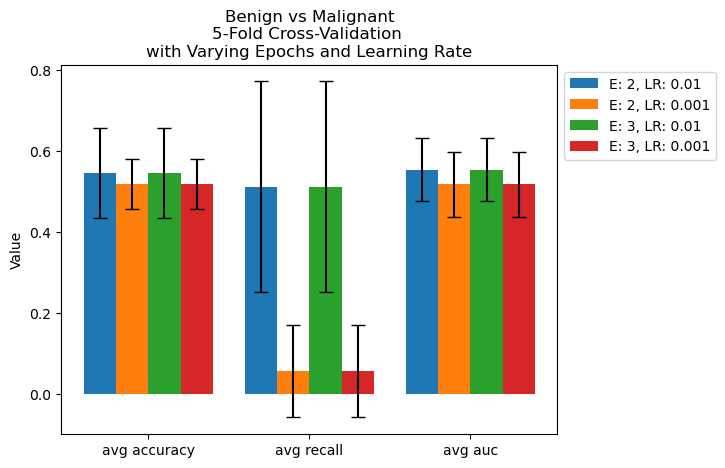

In [10]:
from matplotlib import pyplot as plt



arr_labels = ["avg accuracy", "avg recall", "avg auc"]

arr = list(stats_summary[get_label(2, 0.01)]["mean"].values())
std1 = list(stats_summary[get_label(2, 0.01)]["std"].values())

arr_2 = list(stats_summary[get_label(2, 0.001)]["mean"].values())
std2 = list(stats_summary[get_label(2, 0.001)]["std"].values())

arr_3 = list(stats_summary[get_label(3, 0.01)]["mean"].values())
std3 = list(stats_summary[get_label(3, 0.01)]["std"].values())

arr_4 = list(stats_summary[get_label(3, 0.001)]["mean"].values())
std4 = list(stats_summary[get_label(3, 0.001)]["std"].values())

fig, ax = plt.subplots()

x = np.arange(3)

# Plot the bars
ax.bar(x - 0.3, arr, width=0.2, yerr=std1, capsize=5, label='E: 2, LR: 0.01', bottom=0)
ax.bar(x - 0.1, arr_2, width=0.2, yerr=std2, capsize=5, label='E: 2, LR: 0.001', bottom=0)
ax.bar(x + 0.1, arr_3, width=0.2, yerr=std3, capsize=5, label='E: 3, LR: 0.01', bottom=0)
ax.bar(x + 0.3, arr_4, width=0.2, yerr=std4, capsize=5, label='E: 3, LR: 0.001', bottom=0)



# Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(arr_labels)

# Set labels and title
ax.set_ylabel('Value')
ax.set_title('Benign vs Malignant\n5-Fold Cross-Validation \nwith Varying Epochs and Learning Rate')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))